In [1]:
import torch
import torch.nn.functional as F
from ts_inverse.attack_time_series_utils import SMAPELoss
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ts_inverse.models.vae.timeseries_vae import TimeSeriesVAE
from ts_inverse.models import FCN_Predictor
from ts_inverse.attack_time_series_utils import interpolate
from ts_inverse.workers.attack_worker import get_batch_sample_mapping

/Users/caspar.meijer/Personal/projects/ts-inverse-thesis/ts-inverse-preparation/src/ts_inverse/models/vae/vanilla_vae.py:107: SyntaxWarning: invalid escape sequence '\m'
  """
/Users/caspar.meijer/Personal/projects/ts-inverse-thesis/ts-inverse-preparation/src/ts_inverse/models/vae/timeseries_vae.py:120: SyntaxWarning: invalid escape sequence '\m'
  """


In [ ]:
df_london_smartmeter = pd.read_csv(
    "../data/LondonSmartMeter/london_smart_meters_dataset_without_missing_values_first_30_consumers.csv", index_col="Time", parse_dates=["Time"]
)
df_kddcup = pd.read_csv("../data/KDDCup_2018/kdd_cup_2018_dataset_without_missing_values.csv", index_col="Time", parse_dates=["Time"])
df_electricity_321_hourly = pd.read_csv("../data/Electricity321Hourly/electricity_hourly_dataset.csv", index_col="Time", parse_dates=["Time"])
df_electricity_370 = pd.read_csv("../data/Electricity370/LD2011_2014_first_40_consumers.csv", index_col="Time", parse_dates=["Time"])

In [3]:
from ts_inverse.datahandler import get_datasets, ConcatDataset
from torch.utils.data import DataLoader

aux_dataset_config = {
    "dataset": "london_smartmeter",
    "columns": df_london_smartmeter.columns.tolist()[1:],
    "train_stride": 1,
    "observation_days": 1,
    "future_days": 1,
    "normalize": "minmax",
}
train_sets, val_sets, test_sets = get_datasets(**aux_dataset_config, split_ratio=0.05)
train_set = ConcatDataset(train_sets)

In [4]:
train_loader = DataLoader(train_set, batch_size=(batch_size := 16), shuffle=True)
example_x, _ = next(iter(train_loader))

features = [0]
vae = TimeSeriesVAE(seq_length=96, n_features=len(features), latent_dim=4, hidden_dims=[32, 64, 128, 256])
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

# Training loop
num_epochs = 5
log_interval = 500

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0

    for batch_idx, (batch_x, _) in enumerate(train_loader):
        batch_x = batch_x[:, :, features].to(device)
        if batch_idx == 1:
            print(batch_x.shape)
        batch_x = interpolate(batch_x, 96).permute(0, 2, 1)

        optimizer.zero_grad()

        # Forward pass
        recons, input, mu, log_var = vae(batch_x)

        # Compute loss
        loss_dict = vae.loss_function(recons, input, mu, log_var, M_N=batch_size / len(train_loader.dataset))
        loss = loss_dict["loss"]

        # Backward pass and optimization
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.6f}")

    print(f"====> Epoch: {epoch + 1} Average loss: {train_loss / len(train_loader):.6f}")

Final conv output size: 6
Epoch 1/5 Batch 0/18514 Loss: 0.161558
torch.Size([16, 48, 1])
Epoch 1/5 Batch 500/18514 Loss: 0.007531
Epoch 1/5 Batch 1000/18514 Loss: 0.003741
Epoch 1/5 Batch 1500/18514 Loss: 0.004734
Epoch 1/5 Batch 2000/18514 Loss: 0.004188
Epoch 1/5 Batch 2500/18514 Loss: 0.005685
Epoch 1/5 Batch 3000/18514 Loss: 0.004595
Epoch 1/5 Batch 3500/18514 Loss: 0.004665
Epoch 1/5 Batch 4000/18514 Loss: 0.006323
Epoch 1/5 Batch 4500/18514 Loss: 0.004134
Epoch 1/5 Batch 5000/18514 Loss: 0.004287
Epoch 1/5 Batch 5500/18514 Loss: 0.003661
Epoch 1/5 Batch 6000/18514 Loss: 0.004214
Epoch 1/5 Batch 6500/18514 Loss: 0.003725
Epoch 1/5 Batch 7000/18514 Loss: 0.003969
Epoch 1/5 Batch 7500/18514 Loss: 0.005006
Epoch 1/5 Batch 8000/18514 Loss: 0.004003
Epoch 1/5 Batch 8500/18514 Loss: 0.005792
Epoch 1/5 Batch 9000/18514 Loss: 0.003920
Epoch 1/5 Batch 9500/18514 Loss: 0.007318
Epoch 1/5 Batch 10000/18514 Loss: 0.004028
Epoch 1/5 Batch 10500/18514 Loss: 0.003857
Epoch 1/5 Batch 11000/18514 

Reconstruction shape: torch.Size([2, 1, 96])


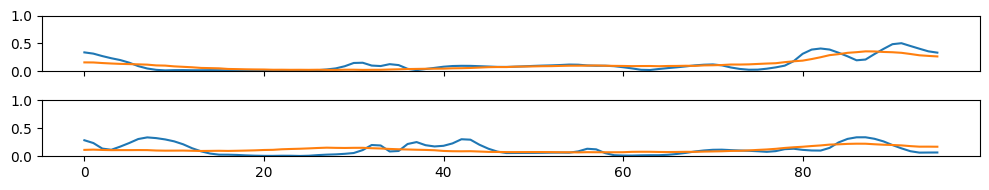

Reconstruction shape: torch.Size([2, 1, 96])


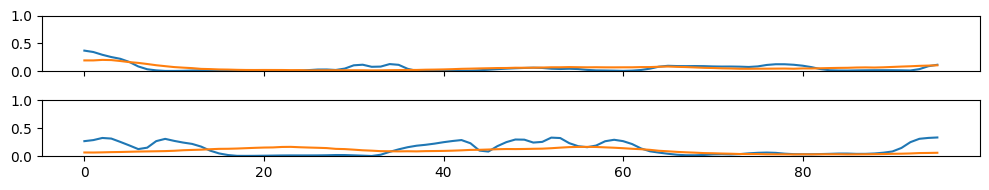

Reconstruction shape: torch.Size([2, 1, 96])


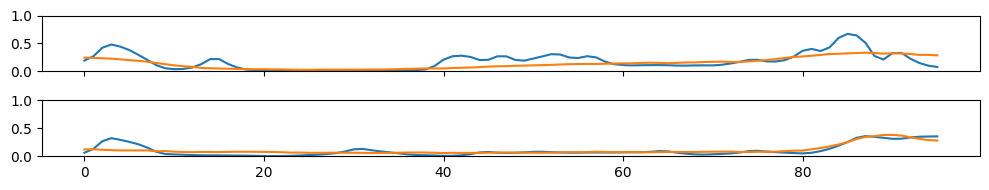

Reconstruction shape: torch.Size([2, 1, 96])


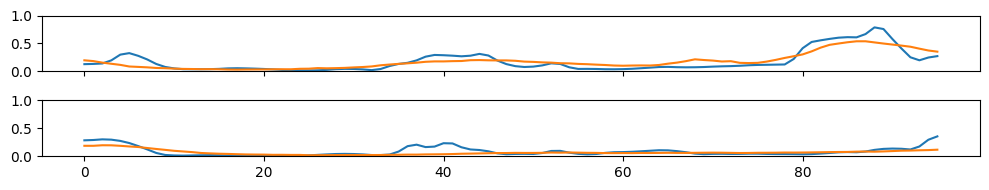

Reconstruction shape: torch.Size([2, 1, 96])


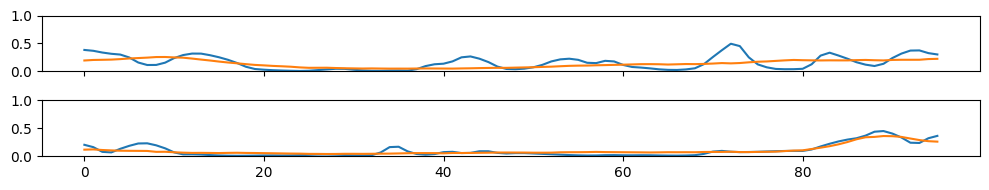

Reconstruction shape: torch.Size([2, 1, 96])


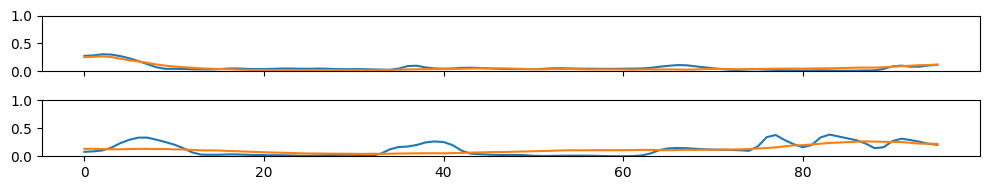

Reconstruction shape: torch.Size([2, 1, 96])


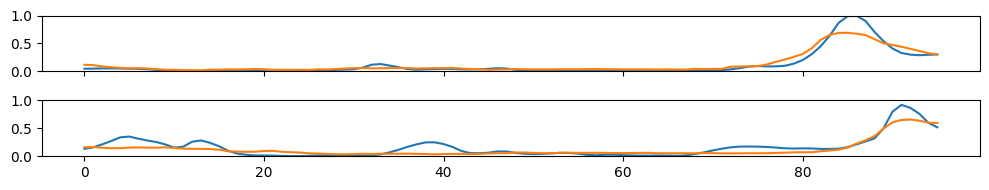

In [5]:
# Plotting function
def plot_examples(original, reconstructed):
    num_examples = original.shape[0]
    fig, axs = plt.subplots(num_examples, 1, figsize=(10, 1 * num_examples), sharex=True)
    if num_examples == 1:
        axs = [axs]

    for i in range(num_examples):
        # Original
        axs[i].plot(original[i].cpu().numpy().T, label=f"Original Example {i + 1}")
        axs[i].plot(reconstructed[i].cpu().numpy().T, label=f"Reconstructed Example {i + 1}")
        axs[i].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()


val_set = ConcatDataset(val_sets)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False)

vae.eval()
with torch.no_grad():
    for i, (val_x, _) in enumerate(val_loader):
        val_x = interpolate(val_x[:, :, features], 96).permute(0, 2, 1).to(device)

        # Generate reconstructions
        reconstructions = vae.generate(val_x)
        print(f"Reconstruction shape: {reconstructions.shape}")
        plot_examples(val_x, reconstructions)
        if i > 5:
            break

In [6]:
# Match the batch samples according to ground truth
def get_sample_mapping(d_x, d_y, a_x, a_y):
    standard_mapping = np.arange(0, a_x.shape[0])
    input_sample_mapping = get_batch_sample_mapping(a_x, d_x)
    target_sample_mapping = get_batch_sample_mapping(a_y, d_y)

    sample_mapping = np.arange(0, a_x.shape[0])
    if not (standard_mapping == input_sample_mapping).all():
        sample_mapping = input_sample_mapping
    if (standard_mapping == input_sample_mapping).all() and not (standard_mapping == target_sample_mapping).all():
        sample_mapping = target_sample_mapping
    return sample_mapping


def plot_original_and_dummy_data(sample_mapping, dummy_inputs, dummy_targets, batch_inputs, batch_targets):
    batch_size = batch_inputs.shape[0]
    original_x_axis = np.arange(0, batch_inputs.shape[1] + batch_targets.shape[1])
    fig, axes = plt.subplots(nrows=batch_size, figsize=(10, 1 * batch_size), sharex=True)
    for i, j in enumerate(sample_mapping):
        ax = axes[i] if batch_size > 1 else axes
        ax.plot(original_x_axis[: batch_inputs.shape[1]], batch_inputs[i, :].detach().cpu().numpy(), label=f"Dataset Input ({i})")
        ax.plot(original_x_axis[: batch_inputs.shape[1]], dummy_inputs[j, :].detach().cpu().numpy(), label=f"Gradient Recovered Input ({j})")

        ax.plot(original_x_axis[batch_inputs.shape[1] :], batch_targets[i, :].detach().cpu().numpy(), label=f"Dataset Target ({i})")
        ax.plot(original_x_axis[batch_inputs.shape[1] :], dummy_targets[j, :].detach().cpu().numpy(), label=f"Gradient Recovered Target ({j})")
        ax.set_ylim(0, 1)
    plt.show()


attack_dataset_config = {
    "dataset": "electricity_370",
    "columns": df_electricity_370.columns.tolist(),
    "train_stride": 24,
    "observation_days": 1,
    "future_days": 1,
    "normalize": "minmax",
}
attack_train_sets, attack_val_sets, attack_test_sets = get_datasets(**attack_dataset_config)
attack_train_set = ConcatDataset(attack_train_sets)
attack_data_loader = DataLoader(attack_train_set, batch_size=(attack_batch_size := 1), shuffle=False)

# Initialize attack data & model
attack_x, attack_y = next(iter(attack_data_loader))
attack_x, attack_y = attack_x[:, :, features].to(device), attack_y[:, :, 0:1].to(device)
print(attack_x.shape, attack_y.shape)
model = FCN_Predictor(features, hidden_size=64, input_size=attack_x.shape[1], output_size=attack_y.shape[1])
model.to(device)

torch.Size([1, 96, 1]) torch.Size([1, 96, 1])


FCN_Predictor(
  (input_fc): Sequential(
    (0): Linear(in_features=96, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (fc): Linear(in_features=64, out_features=96, bias=True)
)

0.3671639859676361 0.5216303467750549


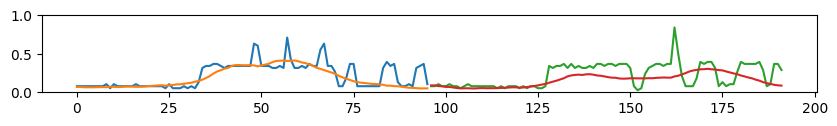

In [7]:
with torch.no_grad():
    reconstructions_x = vae.generate(attack_x.permute(0, 2, 1))
    reconstructions_y = vae.generate(attack_y.permute(0, 2, 1))
    reconstructions_x = interpolate(reconstructions_x.permute(0, 2, 1), attack_x.shape[1])
    reconstructions_y = interpolate(reconstructions_y.permute(0, 2, 1), attack_y.shape[1])
    sample_mapping = get_sample_mapping(reconstructions_x, reconstructions_y, attack_x, attack_y)
    print(SMAPELoss(reconstructions_x[sample_mapping], attack_x).item(), SMAPELoss(reconstructions_y[sample_mapping], attack_y).item())
    plot_original_and_dummy_data(sample_mapping, reconstructions_x, reconstructions_y, attack_x, attack_y)

In [8]:
# Calculate loss and gradients
pred_y = model(attack_x).unsqueeze(-1)
original_y_loss = F.mse_loss(pred_y, attack_y)
original_y_loss.backward()
original_dy_dx = [param.grad.clone() for param in model.parameters()]

58.77080154418945 1.524953007698059 1.4907737970352173


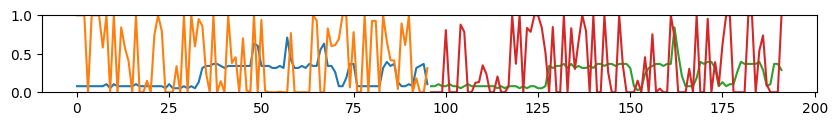

0.04635080695152283 0.004903808236122131 0.005422411952167749


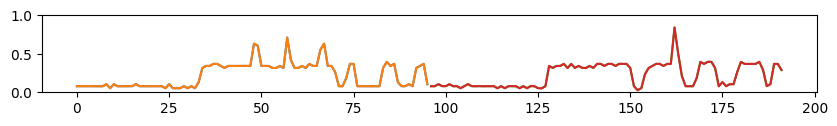

0.047246742993593216 0.005471744108945131 0.005011118948459625


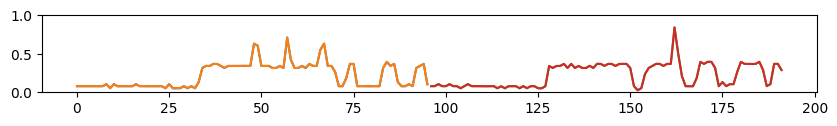

0.041325729340314865 0.004602422472089529 0.00474837701767683


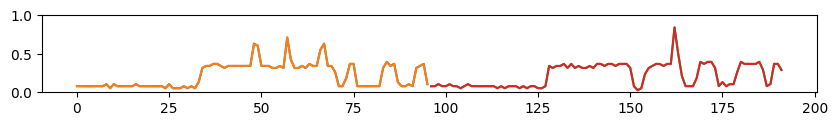

0.039869751781225204 0.0056679509580135345 0.003946226555854082


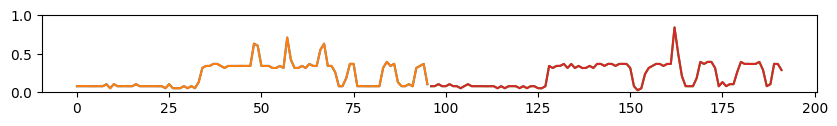

In [9]:
dummy_x = torch.randn_like(attack_x)
dummy_y = torch.randn_like(attack_y)
dummy_x.requires_grad_(True)
dummy_y.requires_grad_(True)

dummy_optimizer = torch.optim.Adam([dummy_x, dummy_y], lr=0.005)

for i in range(5000):

    def closure():
        dummy_optimizer.zero_grad()

        dummy_out = model(dummy_x).unsqueeze(-1)
        dummy_y_loss = F.mse_loss(dummy_out, dummy_y)
        dummy_dy_dx = torch.autograd.grad(dummy_y_loss, model.parameters(), create_graph=True)
        dy_dx_loss = sum((d_g - o_g).abs().sum() for d_g, o_g in zip(dummy_dy_dx, original_dy_dx))

        dy_dx_loss.backward()
        return dy_dx_loss

    dy_dx_loss = dummy_optimizer.step(closure)

    if i % 2 == 0:
        dummy_x.data.clamp_(0, 1)
        dummy_y.data.clamp_(0, 1)

    if i % 1000 == 0:
        with torch.no_grad():
            sample_mapping = get_sample_mapping(dummy_x, dummy_y, attack_x, attack_y)
            print(dy_dx_loss.item(), SMAPELoss(dummy_x[sample_mapping], attack_x).item(), SMAPELoss(dummy_y[sample_mapping], attack_y).item())
            plot_original_and_dummy_data(sample_mapping, dummy_x, dummy_y, attack_x, attack_y)

14.577948570251465 0.7467238306999207 1.0811452865600586


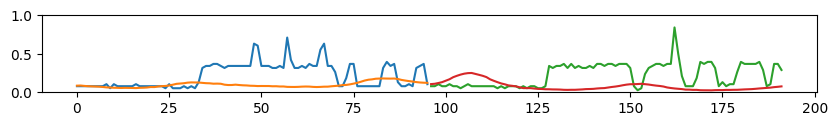

6.210066795349121 0.35769566893577576 0.3665947914123535


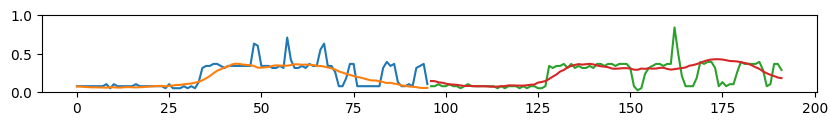

6.129537582397461 0.35650670528411865 0.3668384552001953


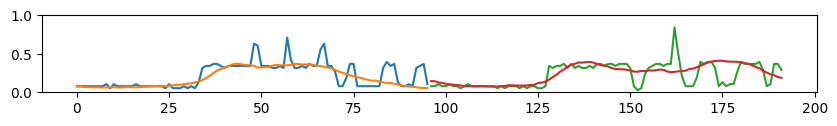

6.129538059234619 0.35653987526893616 0.36683550477027893


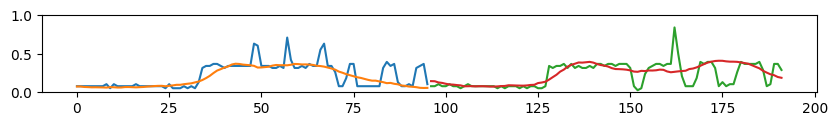

6.129538536071777 0.3565045893192291 0.366836816072464


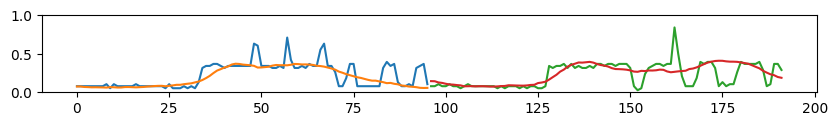

6.129538536071777 0.35650673508644104 0.36683788895606995


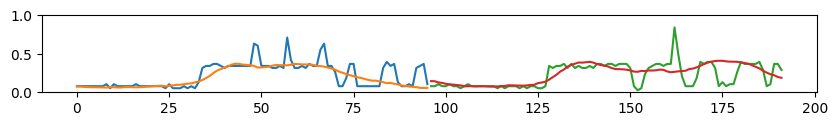

6.129541397094727 0.3565317392349243 0.36684107780456543


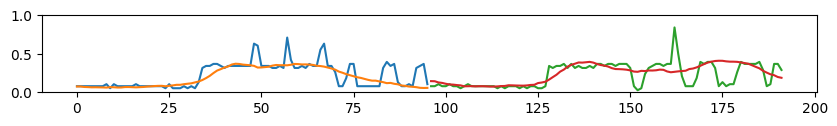

6.129539489746094 0.35660576820373535 0.36683395504951477


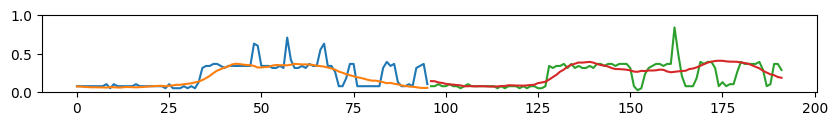

6.129542350769043 0.35649827122688293 0.3668328523635864


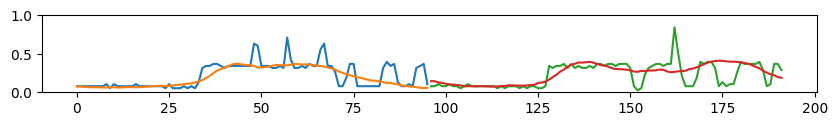

6.129544734954834 0.35653671622276306 0.36683881282806396


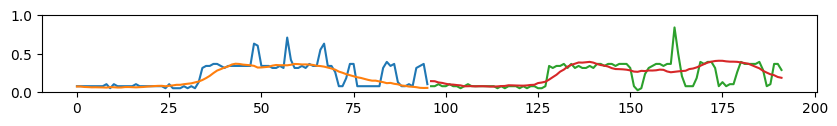

6.129543304443359 0.35642027854919434 0.3668283224105835


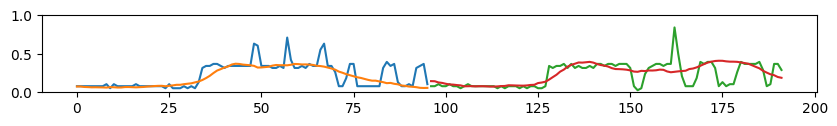

6.129541873931885 0.3565084934234619 0.3668266236782074


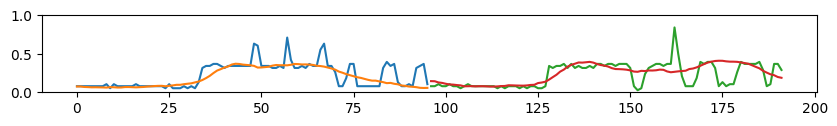

6.12955379486084 0.35659825801849365 0.3668128550052643


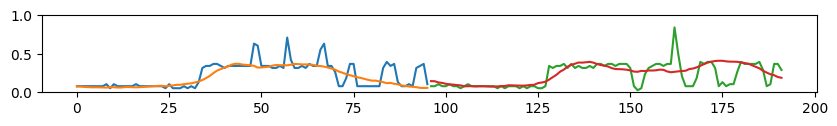

6.129544734954834 0.35627320408821106 0.36682775616645813


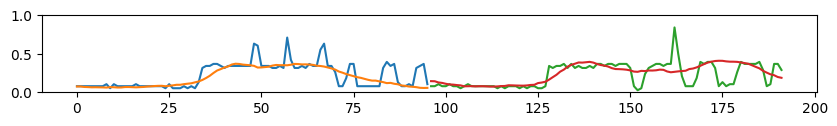

6.129538536071777 0.3565441071987152 0.3668130934238434


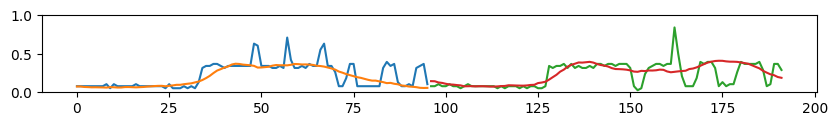

6.1295318603515625 0.3566029369831085 0.3668144643306732


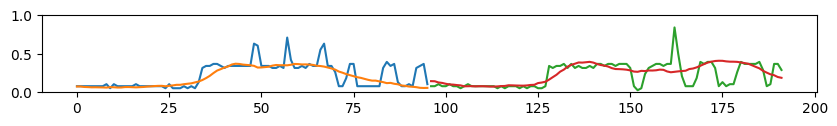

6.129547119140625 0.3563443720340729 0.36684703826904297


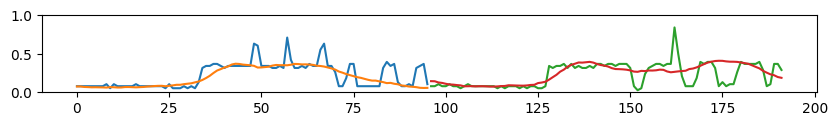

6.129543304443359 0.3567641079425812 0.36679890751838684


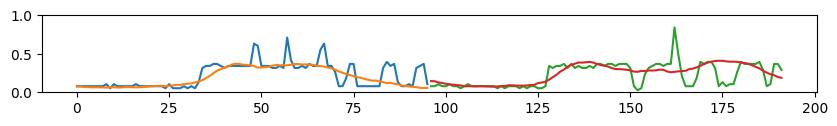

6.129539489746094 0.35614171624183655 0.3668379485607147


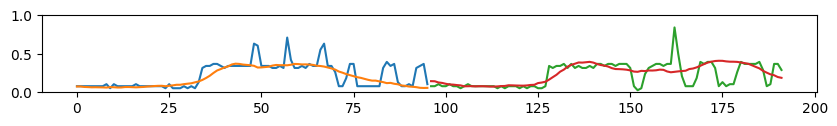

6.1295366287231445 0.35658514499664307 0.36685168743133545


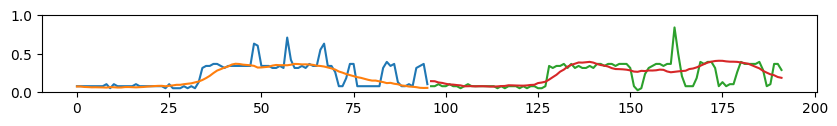

In [10]:
from ts_inverse.attack_time_series_utils import interpolate

dummy_x_latent = torch.randn(attack_batch_size, vae.latent_dim).to(device)
dummy_y_latent = torch.randn(attack_batch_size, vae.latent_dim).to(device)
dummy_x_latent.requires_grad_(True)
dummy_y_latent.requires_grad_(True)

dummy_optimizer = torch.optim.Adam([dummy_x_latent, dummy_y_latent], lr=0.01)

for i in range(10000):

    def closure():
        dummy_optimizer.zero_grad()
        dummy_x = vae.decode(dummy_x_latent)
        dummy_y = vae.decode(dummy_y_latent)

        dummy_x = interpolate(dummy_x.permute(0, 2, 1), attack_x.shape[1])
        dummy_y = interpolate(dummy_y.permute(0, 2, 1), attack_y.shape[1])

        dummy_out = model(dummy_x).unsqueeze(-1)
        dummy_y_loss = F.mse_loss(dummy_out, dummy_y)
        dummy_dy_dx = torch.autograd.grad(dummy_y_loss, model.parameters(), create_graph=True)
        dy_dx_loss = sum((d_g - o_g).abs().sum() for d_g, o_g in zip(dummy_dy_dx, original_dy_dx))

        dy_dx_loss.backward()
        return dy_dx_loss

    dy_dx_loss = dummy_optimizer.step(closure)

    if i % 500 == 0:
        with torch.no_grad():
            dummy_x = vae.decode(dummy_x_latent)
            dummy_y = vae.decode(dummy_y_latent)
            dummy_x = interpolate(dummy_x.permute(0, 2, 1), attack_x.shape[1])
            dummy_y = interpolate(dummy_y.permute(0, 2, 1), attack_y.shape[1])

            sample_mapping = get_sample_mapping(dummy_x, dummy_y, attack_x, attack_y)
            print(dy_dx_loss.item(), SMAPELoss(dummy_x[sample_mapping], attack_x).item(), SMAPELoss(dummy_y[sample_mapping], attack_y).item())
            plot_original_and_dummy_data(sample_mapping, dummy_x, dummy_y, attack_x, attack_y)